# Imports

In [2]:
#!/usr/bin/env python3
"""
finetune_yamnet_tf.py
Full TensorFlow pipeline to fine-tune YAMNet for a small custom label set.
Produces a clip-level classifier on top of YAMNet embeddings, plus sliding-window
inference helper to approximate onset/offset.
"""

import os
import numpy as np
import tensorflow as tf
import sys
import pickle
#%load_ext autoreload

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    path_prefix = ''
else:
    path_prefix = '..'

split = 'train'
file_path = os.path.join(path_prefix, 'data/detection', split)

UNFREEZE_YAMNET = True      # set True to fine-tune YamNet weights (careful: small LR)
TARGET_SR = 16000            # YAMNet requires 16kHz       
RANDOM_SEED = 0

# For sliding-window inference (higher temporal resolution)
SLIDING_WIN_SEC = 1.0   # window length for inference
SLIDING_HOP_SEC = 0.1   # hop between windows -> effective temporal resolution

#%autoreload 2
from src.models.single_stage_yamnet_frame import *

2025-11-30 01:24:48.479768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 01:24:48.498183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 01:24:49.104401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 01:25:06.105425: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [ ]:
data = pickle.load(open('data/processed/yamnet/spectrograms_train.pkl', 'rb'))
print(data.keys())
classes = np.unique(data['event_label'])
NUM_CLASSES = len(classes)
class_to_id = {c:(i+1) for i,c in enumerate(classes)}
print("Classes:", classes)

dict_keys(['sr', 'S_db', 'files', 'onset', 'offset', 'event_label', 'background_label'])


In [5]:
# manual train test split (stratified)
np.random.seed(0)
train_size = 0.8
train_idx = []
for label in np.unique(data['event_label']):
    choices = np.where(data['event_label'] == label)[0]
    train_idx.append(np.sort(np.random.choice(choices, size = int(np.round(len(choices)*train_size)), replace = False)))
train_idx = np.sort(np.concatenate(train_idx))
val_idx = [i for i in range(len(data['event_label'])) if i not in train_idx]
len(train_idx)

400

In [ ]:
filepaths = [os.path.join(file_path, file) for file in data['files']]
labels = [class_to_id[c] for c in data['event_label']]

train_files = [filepaths[i] for i in train_idx]
train_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in train_idx]
val_files = [filepaths[i] for i in val_idx]
val_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in val_idx]
val_onsets = [data['onset'][i] for i in val_idx]
val_offsets = [data['offset'][i] for i in val_idx]

Classes: ['car_horn' 'cough' 'dog_bark' 'gun_shot' 'siren']


In [8]:
trainer = Trainer(train_files, train_labels, val_files, val_labels, lr = 1e-4, epochs = 50, batch_size = 16, model_save_dir = "../src/models/yamnet_framewise.keras")

In [9]:
#trainer.train()
trainer.load_model()

Loaded model from ../src/models/yamnet_framewise.keras


# Inference


In [8]:
i = 0
test_path = val_files[i]
print(f'Actual label: {classes[val_labels[i][2] - 1]}')
print(f'Actual onset: {val_onsets[i]}')
print(f'Actual offset: {val_offsets[i]}')
wav = load_audio_mono(test_path, sr=TARGET_SR)
frame_probs = trainer.predict_frames(wav)  # shape: (n_frames, n_classes)
frame_preds = np.argmax(frame_probs, axis=-1) 
print([classes[i-1] if i!= 0 else '' for i in frame_preds])
actual = labels_to_frames(val_labels[i], 20, audio_length=len(wav)/TARGET_SR)
print([classes[i-1] if i!= 0 else '' for i in actual])

Actual label: siren
Actual onset: 1.4041677639819286
Actual offset: 4.726273878383591
['', '', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', '', '', '', '', '', '', '', '', '', '', '']
['', '', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', '', '', '', '', '', '', '', '', '', '']


In [13]:
i = 4
print(f'Actual label: {classes[val_labels[i][2] - 1]}')
print(f'Actual onset: {val_onsets[i]}')
print(f'Actual offset: {val_offsets[i]}')
test_path = val_files[i]
wav = load_audio_mono(test_path, sr=TARGET_SR)
frame_probs = trainer.predict_frames(wav)  # shape: (n_frames, n_classes)
frame_preds = np.argmax(frame_probs, axis=-1) 
print([classes[i-1] if i!= 0 else '' for i in frame_preds])
actual = labels_to_frames(val_labels[i], 20, audio_length=len(wav)/TARGET_SR)
print([classes[i-1] if i!= 0 else '' for i in actual])

Actual label: dog_bark
Actual onset: 6.460516497831326
Actual offset: 10.0
['', '', '', '', '', '', '', '', '', '', '', '', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark']
['', '', '', '', '', '', '', '', '', '', '', '', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark']


In [11]:
from src.utils.audio_to_spectrograms import *

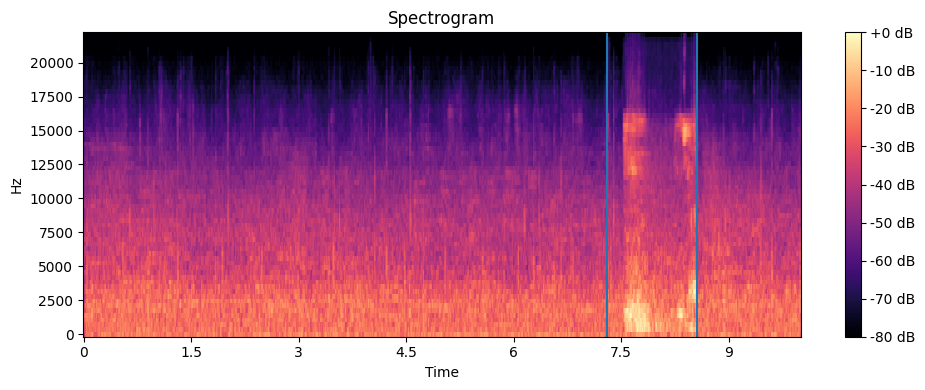

In [12]:
i = 1
display_spectrogram(data['S_db'][val_idx[i]], data['sr'], val_onsets[i], val_offsets[i])